In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import librosa
import pickle
import matplotlib.pyplot as plt
import re
import os
import math
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold

In [2]:
# Mounting Google Drive to access files stored in Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Extracting labels from sessions**

In [3]:
# Define label encoding
emotion_dict = {'ang': 0, 'exc': 1, 'hap': 2, 'sad': 3, 'fru': 4, 'neu': 5, 'fea': -1, 'sur': -1, 'xxx': -1, "dis": -1, 'oth': -1}

In [4]:
info_line = re.compile(r'\[.+\]\n', re.IGNORECASE)
# Initializing lists to store audio file details
start_times, end_times, wav_file_names, emotions = [], [], [], []
# Looping through each session to extract labels
for sess in range(1, 6):
  emo_evaluation_dir = '/content/drive/MyDrive/Dataset/Session{}/dialog/EmoEvaluation/'.format(sess)
  evaluation_files = [l for l in os.listdir(emo_evaluation_dir) if 'Ses' in l]
  for file in evaluation_files:
    with open(emo_evaluation_dir + file) as f:
      content = f.read()
    info_lines = re.findall(info_line, content)
    for line in info_lines[1:]:
      start_end_time, wav_file_name, emotion, val_act_dom = line.strip().split('\t')
      if emotion_dict[emotion] == -1:
        continue
      start_time, end_time = start_end_time[1:-1].split('-')
      start_time, end_time = float(start_time), float(end_time)
      # Appending extracted details to respective lists
      start_times.append(start_time)
      end_times.append(end_time)
      wav_file_names.append(wav_file_name)
      emotions.append(emotion)

In [5]:
# Creating a DataFrame to hold the extracted label data
labels_df = pd.DataFrame(columns=['start_time', 'end_time', 'wav_file', 'emotion'])
labels_df['start_time'] = start_times
labels_df['end_time'] = end_times
labels_df['wav_file'] = wav_file_names
labels_df['emotion'] = emotions
labels_df.head()

,start_time,end_time,wav_file,emotion
0,15.14,17.2100,Ses01F_script02_1_F000,neu
1,25.91,27.4125,Ses01F_script02_1_F001,fru
2,49.22,51.4000,Ses01F_script02_1_F004,neu
3,54.72,57.6900,Ses01F_script02_1_F006,ang
4,57.75,59.5700,Ses01F_script02_1_F007,ang


In [6]:
counts = labels_df['emotion'].value_counts()
counts

,count
emotion,
fru,1849
neu,1708
ang,1103
sad,1084
exc,1041
hap,595


**Building audio vectors**

In [7]:
# Setting directory paths and sampling rate
iemocap_dir = '/content/drive/MyDrive/Dataset/'
sr = 44100
audio_vectors = {}
# Loading audio files and storing waveform data
for sess in range(1, 6):
  wav_file_path = '{}Session{}/dialog/wav/'.format(iemocap_dir, sess)
  orig_wav_files = os.listdir(wav_file_path)
  for orig_wav_file in tqdm(orig_wav_files):
    try:
      orig_wav_vector, _sr = librosa.load(wav_file_path + orig_wav_file, sr=sr)
      orig_wav_file, file_format = orig_wav_file.split('.')
      for index, row in labels_df[labels_df['wav_file'].str.contains(orig_wav_file)].iterrows():
        start_time, end_time, truncated_wav_file_name = row['start_time'], row['end_time'], row['wav_file']
        start_frame = math.floor(start_time * sr)
        end_frame = math.floor(end_time * sr)
        truncated_wav_vector = orig_wav_vector[start_frame:end_frame + 1]
        audio_vectors[truncated_wav_file_name] = truncated_wav_vector
    except:
      print('An exception occured for {}'.format(orig_wav_file))

100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


In [8]:
file_names = []
labels = []
# Looping through sessions
for sess in (range(1,6)):
  for index, row in tqdm(labels_df[labels_df['wav_file'].str.contains('Ses0{}'.format(sess))].iterrows()):
    try:
      wav_file_name = row['wav_file']
      label = emotion_dict[row['emotion']]
      audio_signal = audio_vectors[wav_file_name]
      if len(audio_signal) > 0:
        file_names.append(wav_file_name)
        labels.append(label)
    except Exception as e:
      print('Some exception occurred: {}'.format(e))

file_names = np.array(file_names)
labels = np.array(labels)

1365it [00:00, 18863.63it/s]
1348it [00:00, 18768.39it/s]
1533it [00:00, 20706.44it/s]
1512it [00:00, 19794.09it/s]
1622it [00:00, 20975.46it/s]


**Feature Extraction**

In [9]:
# Function to extract various audio features
def extract_features(data, sample_rate):
  # Zero-Crossing Rate (ZCR)
  result = np.array([])
  zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
  result=np.hstack((result, zcr))

  # Chroma STFT
  stft = np.abs(librosa.stft(data))
  chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
  result = np.hstack((result, chroma_stft))

  # Mel-Frequency Cepstral Coefficients (MFCC)
  mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, mfcc))

  # Root Mean Square (RMS) Value
  rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
  result = np.hstack((result, rms))

  # Mel Spectrogram
  mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, mel))

  return result

In [10]:
# Lists for storing features and labels
x = []
y = []
# Extracting features for each audio sample
for file_name, label in zip(file_names, labels):
  audio_signal = audio_vectors[file_name]
  feature = extract_features(audio_signal, sr)
  x.append(feature)
  y.append(label)

In [11]:
# Converting lists to numpy arrays for compatibility
x = np.array(x)
y = np.array(y)
# Checking data sizes
print(x.shape)
print(y.shape)

(7376, 162)
(7376,)


In [12]:
# Scaling data for consistent feature values
scaler = StandardScaler()
x = scaler.fit_transform(x)

**Training and Testing**

In [13]:
# Function to display confusion matrix
def plot_confusion_matrix(cm, class_names):
    fig, ax = plt.subplots(figsize=(7, 7))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', ax=ax)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Class names for displaying results
class_names = ['Angry', 'Excited', 'Happy', 'Sad', 'Frustrated','Neutral']

XGBoost Accuracy: 0.43902439024390244
XGBoost F1 Score: 0.4265263058785301


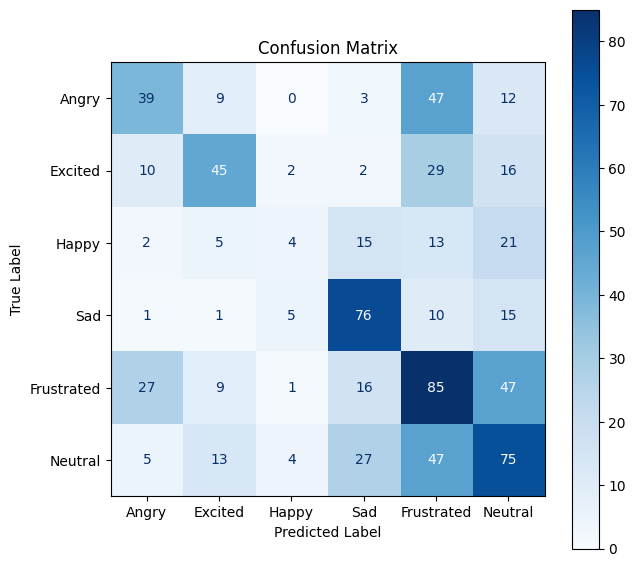

XGBoost Accuracy: 0.47696476964769646
XGBoost F1 Score: 0.4681026276782504


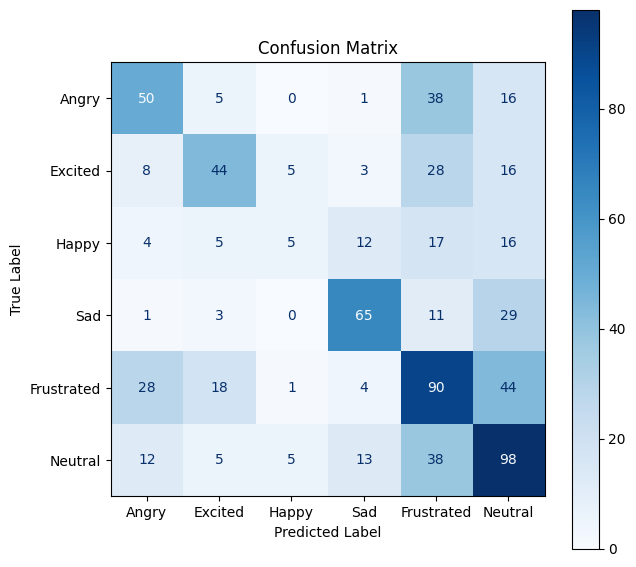

XGBoost Accuracy: 0.5067750677506775
XGBoost F1 Score: 0.5011369535436312


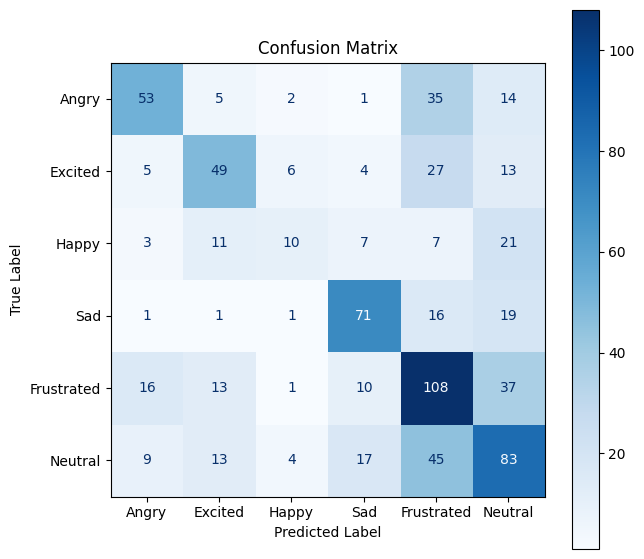

XGBoost Accuracy: 0.4959349593495935
XGBoost F1 Score: 0.4845560850057121


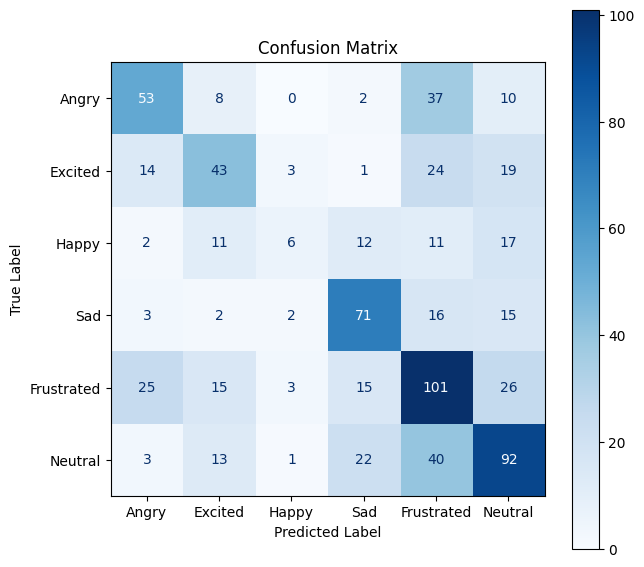

XGBoost Accuracy: 0.5013550135501355
XGBoost F1 Score: 0.4904276675339516


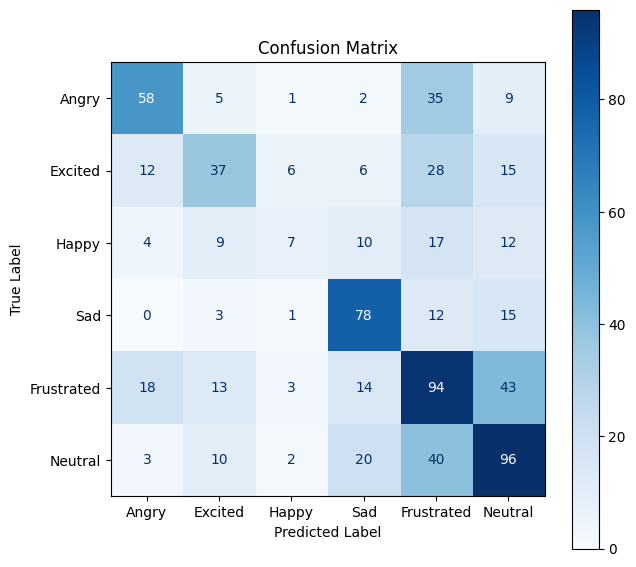

XGBoost Accuracy: 0.45528455284552843
XGBoost F1 Score: 0.4511066587054799


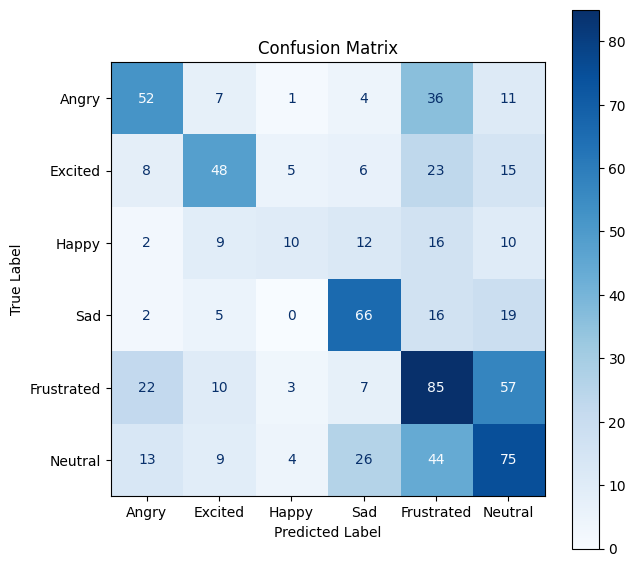

XGBoost Accuracy: 0.5006784260515604
XGBoost F1 Score: 0.4905879462553523


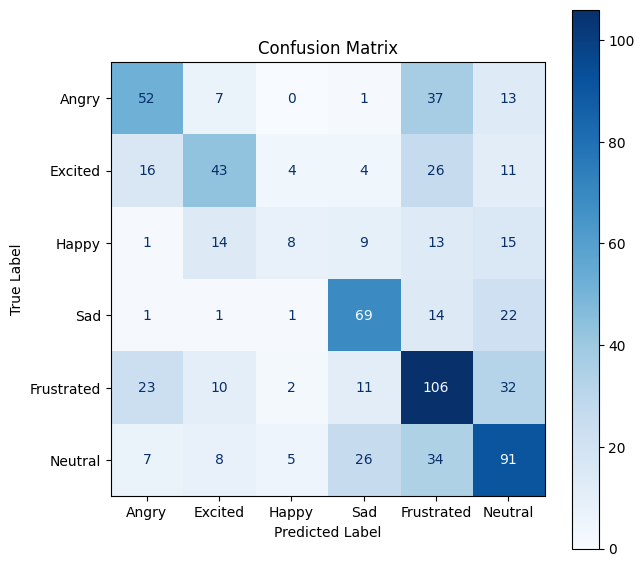

XGBoost Accuracy: 0.4735413839891452
XGBoost F1 Score: 0.4689172285710383


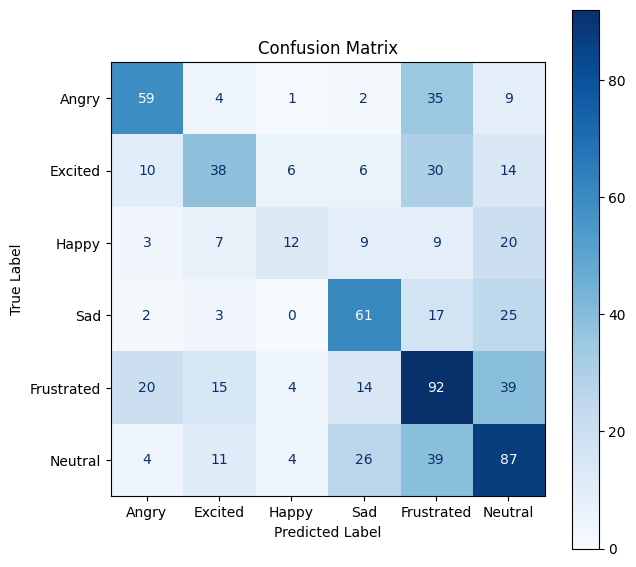

XGBoost Accuracy: 0.49525101763907736
XGBoost F1 Score: 0.4828382280113857


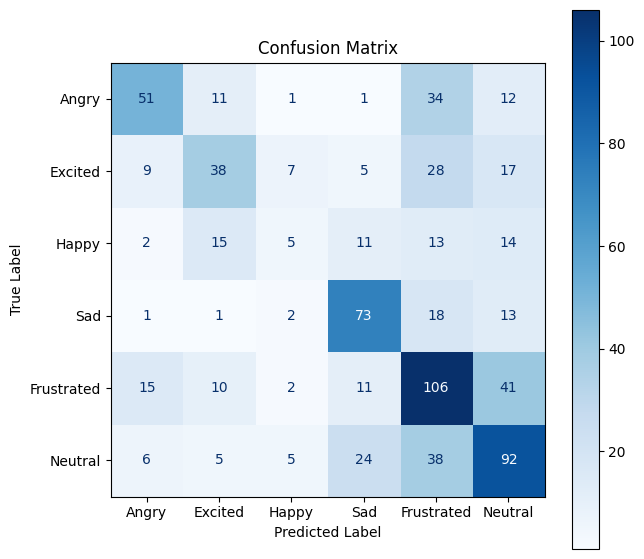

XGBoost Accuracy: 0.46404341926729986
XGBoost F1 Score: 0.4587800278585501


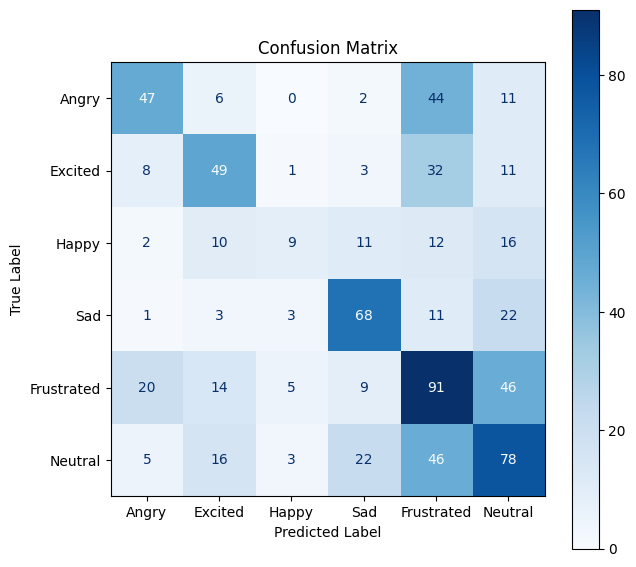

In [14]:
# Lists to store accuracy and F1 scores
accs = []
f1s = []
# Cross-validation with stratified K-Folds
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in skf.split(x, y):
  # Splitting data into training and testing sets
  x_train, x_test = x[train_index], x[test_index]
  y_train, y_test = y[train_index], y[test_index]
  # Initializing and training XGBoost classifier
  xgb_clf = XGBClassifier(n_estimators= 1500, learning_rate=0.1, random_state=42, eval_metric='mlogloss')
  xgb_clf.fit(x_train, y_train)
  xgb_predictions = xgb_clf.predict(x_test)
  # Calculating accuracy and F1 score
  xgb_accuracy = accuracy_score(y_test, xgb_predictions)
  print("XGBoost Accuracy:", xgb_accuracy)
  xgb_f1 = f1_score(y_test, xgb_predictions, average='weighted')
  print(f"XGBoost F1 Score: {xgb_f1}")
  # Storing accuracy and F1 scores
  accs.append(xgb_accuracy)
  f1s.append(xgb_f1)
  # Compute confusion matrix
  cm = confusion_matrix(y_test, xgb_predictions)
  plot_confusion_matrix(cm, class_names)

In [15]:
# Computing mean of accuracies and F1 scores across all folds
print("Mean XGBoost Accuracy:", np.mean(accs))
print("Mean XGBoost F1 Score:", np.mean(f1s))

Mean XGBoost Accuracy: 0.4808853000334617
Mean XGBoost F1 Score: 0.4722979729041882
